# SETUP

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import duckdb as ddb
from tabulate import tabulate
import statsmodels.api as sm
import yfinance as yf

ddb.connect(':memory:')


def print_df(df):
    print(tabulate(df, headers='keys', tablefmt='psql'))

In [44]:
start = '2023-01-01'
end = '2024-12-05'

def get_price_history(ticker, start, end):
    raw = yf.download(ticker, start=start, end=end)
    raw.columns = raw.columns.droplevel(1)
    raw['Date'] = raw.index
    return raw

btc_raw = get_price_history('BTC-USD', start, end)
wulf_raw = get_price_history('WULF', start, end)
mstr_raw = get_price_history('MSTR', start, end)
wmt_raw = get_price_history('WMT', start, end)
eth_raw = get_price_history('ETH-USD', start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# PREPARE DATA

In [45]:
min_date = '2023-01-01'
max_date = '2024-12-05'

q = '''
    SELECT
        b.Date,
        b.Close AS btc_close,
        w.Close AS wulf_close,
        wmt.Close AS wmt_close,
        m.Close AS mstr_close,
        e.Close AS eth_close
    FROM btc_raw b
    INNER JOIN wulf_raw w ON CAST(b.Date AS DATE) = CAST(w.Date AS DATE)
    INNER JOIN wmt_raw wmt ON CAST(b.Date AS DATE) = CAST(wmt.Date AS DATE)
    INNER JOIN mstr_raw m ON CAST(b.Date AS DATE) = CAST(m.Date AS DATE)
    INNER JOIN eth_raw e ON CAST(b.Date AS DATE) = CAST(e.Date AS DATE)
    ORDER BY w.Date
'''

df = ddb.execute(q).fetchdf()
df['btc_close_diff'] = df['btc_close'].diff()
df['wulf_close_diff'] = df['wulf_close'].diff()
df['mstr_close_diff'] = df['mstr_close'].diff()
df['wmt_close_diff'] = df['wmt_close'].diff()
df['eth_close_diff'] = df['eth_close'].diff()
df.dropna(inplace=True)
print('TABLE')
print_df(df.tail(5))
print('\nDESCRIBE')
print_df(df.describe())

TABLE
+-----+---------------------+-------------+--------------+-------------+--------------+-------------+------------------+-------------------+-------------------+------------------+------------------+
|     | Date                |   btc_close |   wulf_close |   wmt_close |   mstr_close |   eth_close |   btc_close_diff |   wulf_close_diff |   mstr_close_diff |   wmt_close_diff |   eth_close_diff |
|-----+---------------------+-------------+--------------+-------------+--------------+-------------+------------------+-------------------+-------------------+------------------+------------------|
| 479 | 2024-11-27 00:00:00 |     95962.5 |         7.29 |       91.88 |       388.84 |     3657.25 |         3977.21  |         0.72      |          35.15    |         0.57     |         330.732  |
| 480 | 2024-11-29 00:00:00 |     97461.5 |         7.89 |       92.5  |       387.47 |     3593.49 |         1498.99  |         0.6       |          -1.37    |         0.620003 |         -63.7549 |

### FUNCTION - find_relationship

In [46]:
def find_relationship(df, col1, col2):
    X = df[[col1]]
    y = df[col2]

    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()

    y_pred = model.predict(X)

    r2 = model.rsquared

    p_value = model.pvalues[col1]
    confidence = .95
    relationship_significant = p_value <= 1 - confidence

    plt.figure(figsize=(10,6))
    plt.scatter(X[col1], y, color='blue', label='Actual Data', s=15)
    plt.plot(X[col1], y_pred, color='red', label='Regression Line')
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.legend()
    plt.show()

    # Print model details
    print(f'Linear Regression Model: y = {model.params['const']} + {model.params[col1]} * {col1}')
    print(f'R-squared: {r2:.4f}')
    print(f'Relationship Significant at {int(confidence * 100)}%: {relationship_significant}')

# BTC vs WULF

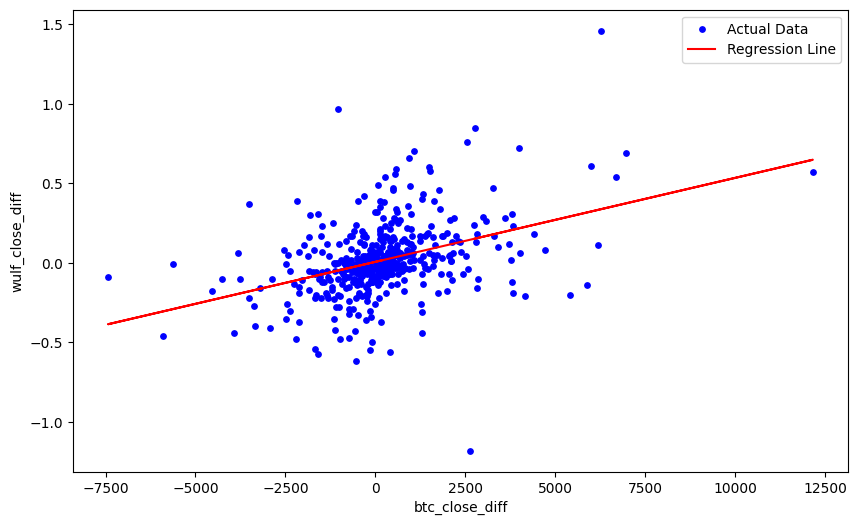

Linear Regression Model: y = 0.006369823851524368 + 5.2788951077508975e-05 * btc_close_diff
R-squared: 0.1569
Relationship Significant at 95%: True


In [47]:
find_relationship(df, 'btc_close_diff', 'wulf_close_diff')

# BTC vs MSTR

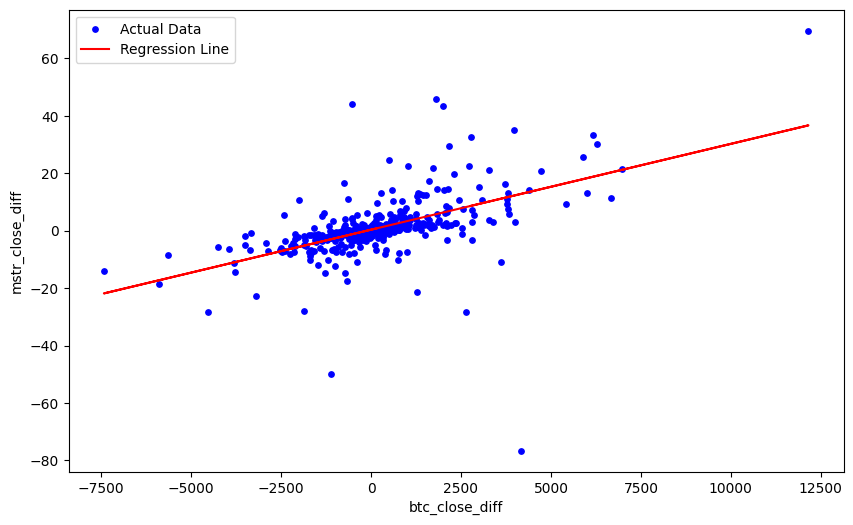

Linear Regression Model: y = 0.30295436964539246 + 0.0029866609871121363 * btc_close_diff
R-squared: 0.2956
Relationship Significant at 95%: True


In [48]:
find_relationship(df, 'btc_close_diff', 'mstr_close_diff')

# BTC vs WMT

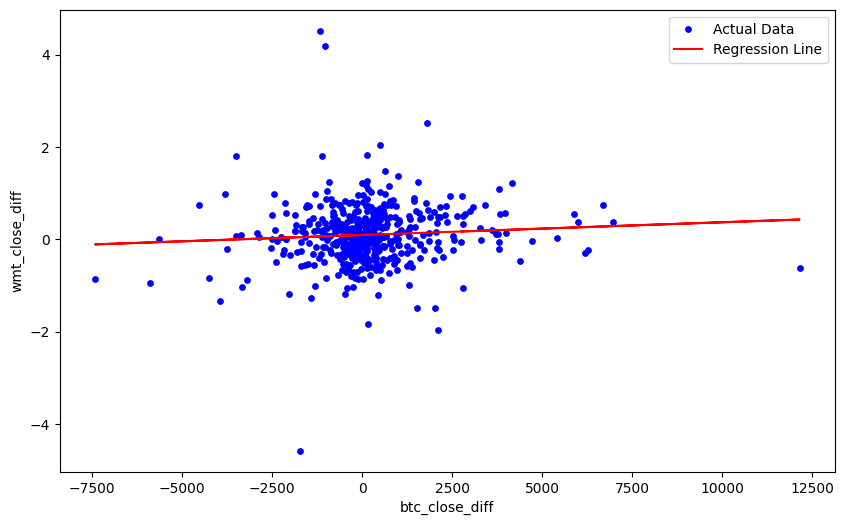

Linear Regression Model: y = 0.09177375973745473 + 2.7489813011286732e-05 * btc_close_diff
R-squared: 0.0053
Relationship Significant at 95%: False


In [49]:
find_relationship(df, 'btc_close_diff', 'wmt_close_diff')

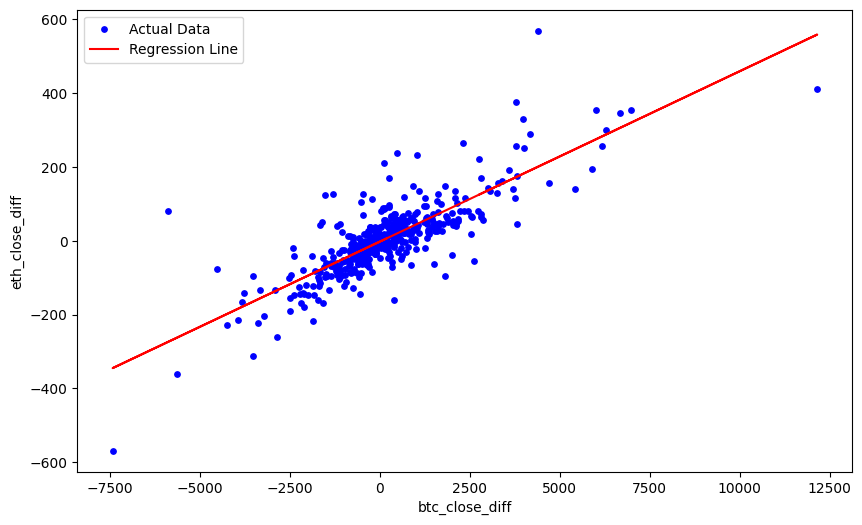

Linear Regression Model: y = -2.411265127001062 + 0.04618412170201652 * btc_close_diff
R-squared: 0.6545
Relationship Significant at 95%: True


In [50]:
find_relationship(df, 'btc_close_diff', 'eth_close_diff')